In [1]:
import torch, platform, sys
print("Python:", sys.executable)
print("PyTorch:", torch.__version__)
print("CUDA disponível?", torch.cuda.is_available())
mps_ok = getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
print("MPS (Apple) disponível?", bool(mps_ok))

Python: /opt/conda/envs/anaconda-ai-2024.04-py310/bin/python
PyTorch: 2.2.0
CUDA disponível? False
MPS (Apple) disponível? False


In [2]:
import torch
import matplotlib.pyplot as plt
from torch.autograd import grad

In [3]:
u = lambda x, y: 0 * x ** 2 * y ** 2  # needed to force pytorch to evaluate gradient
v = lambda x, y: -1.7004e-7 * y ** 2 + x ** 2 * y ** 2 * 0

In [4]:
nx = 5
ny = 5

x = torch.linspace(-1, 1, nx, requires_grad=True)
y = torch.linspace(-1, 1, ny, requires_grad=True)
x, y = torch.meshgrid(x, y, indexing="ij")

In [5]:
d = torch.cat((u(x, y).unsqueeze(0), v(x, y).unsqueeze(0)), 0)
# the following is achieved by the concatenation
# d[0, :, :] == u(x,y)
# d[1, :, :] == v(x,y)

In [8]:
dd_dx = torch.zeros((2, 2, nx, ny))
dd_dx[0, 0] = grad(d[0], x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]
dd_dx[0, 1] = grad(d[0], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
dd_dx[1, 0] = grad(d[1], x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]
dd_dx[1, 1] = grad(d[1], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]

In [7]:
dd_dx = torch.zeros((2, 2, nx, ny))
dd_dx[0, 0] = grad(d[0], x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]  # dd_dxdx
dd_dx[0, 1] = grad(d[0], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]  # dd_dxdy
dd_dx[1, 0] = grad(d[1], x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]  # dd_dydx
dd_dx[1, 1] = grad(d[1], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]  # dd_dydy

In [9]:
eps = 0.5 * (dd_dx + dd_dx.permute((1, 0, 2, 3)))

In [10]:
E = 210000.0
nu = 0.3

C = torch.zeros((2, 2, 2, 2))  # 4th order material tensor
C[0, 0, 0, 0] = 1.0
C[0, 0, 1, 1] = nu
C[1, 1, 0, 0] = nu
C[1, 1, 1, 1] = 1.0
C[0, 1, 0, 1] = (1.0 - nu) / 2.0
C = E / (1.0 - nu ** 2) * C

In [11]:
sig = torch.tensordot(C, eps)

In [20]:
dsig11_dx = grad(
    sig[0, 0], x, torch.ones_like(x), create_graph=True, retain_graph=True
)[0]
dsig12_dy = grad(
    sig[0, 1], y, torch.ones_like(y), create_graph=True, retain_graph=True
)[0]
dsig21_dx = grad(
    sig[1, 0], x, torch.ones_like(x), create_graph=True, retain_graph=True
)[0]
dsig22_dy = grad(
    sig[1, 1], y, torch.ones_like(y), create_graph=True, retain_graph=True
)[0]

f = torch.zeros((2, nx, ny))
f[0] = -dsig11_dx - dsig12_dy  # out of balance force in x1
f[1] = -dsig21_dx - dsig22_dy  # out of balance force in x2

In [13]:
# your code goes here: compute the density

In [18]:
g = 9810
rho = f[1] / g
print(rho)

tensor([[8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06]],
       grad_fn=<DivBackward0>)


In [21]:
grad(sig[1, 0], x, torch.ones_like(x), create_graph=True, retain_graph=True, allow_unused=True)

(tensor([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]], grad_fn=<AddBackward0>),)

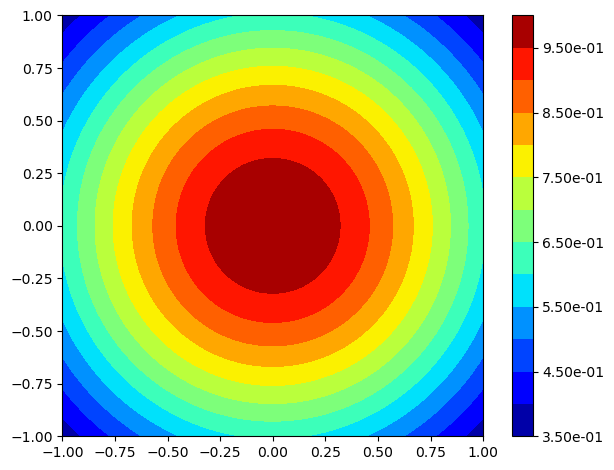

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def to_np(a):
    return a.detach().cpu().numpy() if isinstance(a, torch.Tensor) else np.asarray(a)

# --------------------------
# 1) Resolver/definir a malha (Xg, Yg)
# --------------------------
Xg = Yg = None

if 'X' in globals() and 'Y' in globals():                   # caso A: já tem X,Y 2D
    Xg, Yg = to_np(X), to_np(Y)
elif 'x' in globals() and 'y' in globals():                 # caso B: tem x,y 1D
    xv, yv = to_np(x).reshape(-1), to_np(y).reshape(-1)
    Xg, Yg = np.meshgrid(xv, yv, indexing='ij')

# --------------------------
# 2) Resolver/definir o escalar rho
# --------------------------
if 'rho' in globals():                                      # use rho existente
    Z = globals()['rho']
else:
    # Tentar construir rho a partir de campos já existentes (ordem de preferência)
    if 'sig' in globals():                                  # von Mises (plano)
        s11 = globals()['sig'][0,0]
        s22 = globals()['sig'][1,1]
        s12 = globals()['sig'][0,1]
        Z = torch.sqrt(s11**2 - s11*s22 + s22**2 + 3.0*s12**2)
    elif 'd' in globals():                                  # módulo do deslocamento
        Z = torch.sqrt(globals()['d'][0]**2 + globals()['d'][1]**2)
    elif 'f' in globals():                                  # módulo de -div(sigma)
        Z = torch.sqrt(globals()['f'][0]**2 + globals()['f'][1]**2)
    elif 'eps' in globals():                                # um componente de deformação
        Z = globals()['eps'][0,0]
    else:
        # Nada disponível: cria um campo sintético e uma malha, se precisar
        if Xg is None or Yg is None:
            nx = ny = 100
            xv = np.linspace(-1, 1, nx)
            yv = np.linspace(-1, 1, ny)
            Xg, Yg = np.meshgrid(xv, yv, indexing='ij')
        Z = torch.from_numpy(np.exp(-0.5*(Xg**2 + Yg**2)))

# --------------------------
# 3) Se ainda não havia malha, inferir da forma de Z
# --------------------------
Znp = to_np(Z)
if Xg is None or Yg is None:
    nx, ny = Znp.shape
    xv = np.arange(nx)
    yv = np.arange(ny)
    Xg, Yg = np.meshgrid(xv, yv, indexing='ij')

# Ajustar orientação se necessário
if Znp.shape != Xg.shape:
    if Znp.T.shape == Xg.shape:
        Znp = Znp.T
    else:
        raise ValueError(f"Shape de rho {Znp.shape} não corresponde à malha {Xg.shape}.")

# --------------------------
# 4) Plot
# --------------------------
fig, ax = plt.subplots()
cp = ax.contourf(Xg, Yg, Znp, levels=12, cmap=plt.cm.jet)  # igual ao seu cmap
fig.colorbar(cp, ax=ax, format="%.2e")
ax.set_aspect("equal", adjustable='box')
fig.tight_layout()
plt.show()

